<a href="https://colab.research.google.com/github/Carhuacusma/CC62_Data_Mining_TB_20202/blob/master/TB_Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TB: CC62 Data Mining
## Kaggle: ATLAS experiment Higss Boson

## Objectives:

- Detection of the Higgs Boson in simulated data in order to reproduce the behavior of the ATLAS experience. 
- Binary classification problem, or event detection.
- Using simulated data with features characterizing events detected by ATLAS, the task is to classify events into **"tau tau decay of a Higgs boson"** versus **"background"**. 

## Understanding the Data


The ATLAS experiment observed a signal of the Higgs boson **decaying into two tau particles**, but this decay is a small signal buried in **background** noise. The goal of the challenge is to explore the potential of advanced machine learning methods to improve the discovery significance of the experiment.

In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif

In [ ]:
# Read file
dfHiggsBoson = pd.read_csv("training.csv")
print(dfHiggsBoson.shape)
print(dfHiggsBoson.head())

(250000, 33)
   EventId  DER_mass_MMC  ...    Weight  Label
0   100000       138.470  ...  0.002653      s
1   100001       160.937  ...  2.233584      b
2   100002      -999.000  ...  2.347389      b
3   100003       143.905  ...  5.446378      b
4   100004       175.864  ...  6.245333      b

[5 rows x 33 columns]


We have 250 000 rows, with 33 attributes

In [ ]:
def analizarColumns(dataframe):
  def auxRango(arr):
    cmin, cmax = '-','-'
    if arr.dtype == 'int64' or arr.dtype == 'float64':
      cmin = np.min(arr)
      cmax = np.max(arr)
    return cmin, cmax
  i = 1
  print("%3s | %27s | %7s | %25s"%("#","Name","Type", "Range"))
  for columna in dataframe:
    cmin, cmax = auxRango(dataframe[columna])
    print("%3s | %27s | %7s | %20s - %s"%( i,
        columna, dataframe[columna].dtype, cmin, cmax
        ))
    i+=1

In [ ]:
analizarColumns(dfHiggsBoson)

  # |                        Name |    Type |                     Range
  1 |                     EventId |   int64 |               100000 - 128463
  2 |                DER_mass_MMC | float64 |               -999.0 - 858.887
  3 | DER_mass_transverse_met_lep | float64 |                0.002 - 690.075
  4 |                DER_mass_vis | float64 |                 7.33 - 651.561
  5 |                    DER_pt_h | float64 |                  0.0 - 2834.9990000000003
  6 |        DER_deltaeta_jet_jet | float64 |               -999.0 - 8.459
  7 |            DER_mass_jet_jet | float64 |               -999.0 - 3624.1540000000005
  8 |         DER_prodeta_jet_jet | float64 |               -999.0 - 14.717
  9 |          DER_deltar_tau_lep | float64 |                0.228 - 5.684
 10 |                  DER_pt_tot | float64 |                  0.0 - 2834.9990000000003
 11 |                  DER_sum_pt | float64 |   46.306000000000004 - 1216.476
 12 |        DER_pt_ratio_lep_tau | float64 |        

The description of the variables are in the OpenData page of CERN. From theese, we can remark:

- **EventId**: An unique integer identifier of the event.
- **DER_mass_MMC**: The estimated mass of the Higgs boson candidate.
- **PRI_jet_num**: The number of jets (integer with value of 0, 1, 2 or 3; possible larger values have been capped at 3). **According to the page, some variables are *undefined* if the value of PRI_jet_num is below 1.**
- **Weight**	The event weight wi
- **Label**	The event label (string) yi ∈ {s,b} (s for signal, b for background).

In [ ]:
dfHiggsBoson[dfHiggsBoson['PRI_jet_num'] == 0]

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
3,100003,143.905,81.417,80.943,0.414,-999.0,-999.0,-999.0,3.310,0.414,75.968,2.354,-1.285,-999.0,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-0.0,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.0,-999.0,-999.0,3.891,16.405,57.983,1.056,-1.385,-999.0,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,6.245333,b
8,100008,105.594,50.559,100.989,4.288,-999.0,-999.0,-999.0,2.904,4.288,65.333,0.675,-1.366,-999.0,39.008,2.433,-2.532,26.325,0.210,1.884,37.791,0.024,129.804,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,5.296003,b
10,100010,-999.000,86.240,79.692,27.201,-999.0,-999.0,-999.0,2.338,27.201,81.734,1.750,-1.412,-999.0,29.718,-0.866,2.878,52.016,0.126,-1.288,51.276,0.688,250.178,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,2.299504,b
13,100013,82.488,31.663,64.128,8.232,-999.0,-999.0,-999.0,2.823,8.232,58.649,1.303,-1.414,-999.0,25.470,-0.654,-2.990,33.179,-1.665,-0.354,12.439,1.433,163.420,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,2.183892,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249990,349990,127.822,82.865,100.024,0.860,-999.0,-999.0,-999.0,3.210,0.860,71.325,2.322,-1.321,-999.0,21.474,-0.640,1.618,49.852,1.391,-0.867,35.847,2.674,120.320,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-0.0,6.346934,b
249995,349995,-999.000,71.989,36.548,5.042,-999.0,-999.0,-999.0,1.392,5.042,55.892,1.258,-1.414,-999.0,24.754,-0.414,-0.905,31.137,-0.950,0.380,46.520,2.859,144.665,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,4.505083,b
249996,349996,-999.000,58.179,68.083,22.439,-999.0,-999.0,-999.0,2.585,22.439,50.618,1.162,-1.345,-999.0,23.416,-1.609,2.776,27.202,0.308,1.042,46.737,-0.867,80.408,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-0.0,2.497259,b
249998,349998,94.951,19.362,68.812,13.504,-999.0,-999.0,-999.0,3.365,13.504,55.859,0.999,1.414,-999.0,27.944,-2.211,2.792,27.915,-0.874,-0.296,12.150,0.811,112.718,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,1.681611,b


Even in the instances where some values would be undefined, according to the OpenData page, every cell is filled with a number.

## Preprocessing:

First we drop the column EventId (since it's redundant with our info and would affect the calculations) and Label. We get a dataframe with only numerical values

In [ ]:
X_numerics = dfHiggsBoson.drop(['EventId','Label'],axis=1)
analizarColumns(X_numerics)

  # |                        Name |    Type |                     Range
  1 |                DER_mass_MMC | float64 |               -999.0 - 1192.026
  2 | DER_mass_transverse_met_lep | float64 |                  0.0 - 690.075
  3 |                DER_mass_vis | float64 |                6.329 - 1349.351
  4 |                    DER_pt_h | float64 |                  0.0 - 2834.9990000000003
  5 |        DER_deltaeta_jet_jet | float64 |               -999.0 - 8.503
  6 |            DER_mass_jet_jet | float64 |               -999.0 - 4974.979
  7 |         DER_prodeta_jet_jet | float64 |               -999.0 - 16.69
  8 |          DER_deltar_tau_lep | float64 |  0.20800000000000002 - 5.684
  9 |                  DER_pt_tot | float64 |                  0.0 - 2834.9990000000003
 10 |                  DER_sum_pt | float64 |               46.104 - 1852.4620000000002
 11 |        DER_pt_ratio_lep_tau | float64 |                0.047 - 19.773
 12 |      DER_met_phi_centrality | float64 |  -1.41

For now, we see a large range of values in every column.

In [ ]:
print(X_numerics)

        DER_mass_MMC  DER_mass_transverse_met_lep  ...  PRI_jet_all_pt    Weight
0            138.470                       51.655  ...         113.497  0.002653
1            160.937                       68.768  ...          46.226  2.233584
2           -999.000                      162.172  ...          44.251  2.347389
3            143.905                       81.417  ...          -0.000  5.446378
4            175.864                       16.915  ...           0.000  6.245333
...              ...                          ...  ...             ...       ...
249995      -999.000                       71.989  ...           0.000  4.505083
249996      -999.000                       58.179  ...          -0.000  2.497259
249997       105.457                       60.526  ...          41.992  0.018636
249998        94.951                       19.362  ...           0.000  1.681611
249999      -999.000                       72.756  ...           0.000  1.877474

[250000 rows x 31 columns]


We could not find any NaN (Not a Number) value in the dataframe.

#### Normalize the data:

In [ ]:
nombres = list(X_numerics.columns.values)
print("Normalizing X_numerics and preserving the names:")
X_num_normalized = pd.DataFrame(preprocessing.normalize(X_numerics, norm='l1'),columns=nombres)
analizarColumns(X_num_normalized)
print("With a size of: ")
print(X_num_normalized.shape)

Normalizing X_numerics and preserving the names:
  # |                        Name |    Type |                     Range
  1 |                DER_mass_MMC | float64 |  -0.5885695175049144 - 0.38944942815681294
  2 | DER_mass_transverse_met_lep | float64 |                  0.0 - 0.1454660531342969
  3 |                DER_mass_vis | float64 | 0.0006805606976956945 - 0.27470631603135137
  4 |                    DER_pt_h | float64 |                  0.0 - 0.14705454207584906
  5 |        DER_deltaeta_jet_jet | float64 |  -0.1352304967427218 - 0.00496292241815096
  6 |            DER_mass_jet_jet | float64 |  -0.1352304967427218 - 0.784858616845644
  7 |         DER_prodeta_jet_jet | float64 |  -0.1352304967427218 - 0.017528066506048576
  8 |          DER_deltar_tau_lep | float64 | 2.3760187882774496e-05 - 0.004651340882868247
  9 |                  DER_pt_tot | float64 |                  0.0 - 0.1467848338073409
 10 |                  DER_sum_pt | float64 | 0.0032876190052499926 - 0.23634

Now the ranges are less widened, and with 250,000 instances, we can divide the data in two sets: Training (200 000) and Test (50 000).

In [ ]:
X_train = X_num_normalized.values[:200000]
print(X_train.shape)
X_test = X_num_normalized.values[200000:]
print(X_test.shape)

(200000, 31)
(50000, 31)


## Defining a model

In [ ]:
## Esto es solo como auxiliar para no perderme con el material XD
def entropia(columna):
  n = len(columna)
  valores = pd.unique(columna)
  ent = 0
  for valor in valores:
    pi = len(columna[columna == valor])/n # P(i) = n(i) / n(Omega)
    ent += -1*pi*math.log2(pi)
  return ent

From the original dataframe we extract the array for the class that will be the target for prediction 

In [ ]:
print(dfHiggsBoson.values[:,-1])
target = dfHiggsBoson.values[:,-1]

['s' 'b' 'b' ... 's' 'b' 'b']


In [ ]:
Target_train = target[:200000]
print(len(Target_train))
print(X_train.shape)

200000
(200000, 31)


The Target_train array has the target class for the X_train set

In [ ]:
## TODO: Averiguar sobre la función
InfoGain_Train = mutual_info_classif(X_train, Target_train)

Now we have an array with the InfoGain for every column, but for better understanding, we can pass the information to a dictionary and label it.

In [ ]:
dicInfoGain = dict(zip(nombres,InfoGain_Train))
sort_InfoGain = sorted(dicInfoGain.items(), key=lambda x: x[1])
print(sort_InfoGain)

[('PRI_tau_eta', 0.004997702190500775), ('PRI_lep_eta', 0.005986641881269517), ('DER_pt_tot', 0.006540453194447959), ('PRI_met_phi', 0.008709481141118136), ('PRI_tau_phi', 0.008998610764064274), ('PRI_lep_phi', 0.009217766120786619), ('PRI_lep_pt', 0.011338969738186488), ('DER_pt_h', 0.02094842499435301), ('PRI_jet_all_pt', 0.026523738393040563), ('PRI_jet_num', 0.026911465134547008), ('DER_pt_ratio_lep_tau', 0.027181326535281602), ('PRI_met', 0.02934930647973988), ('DER_deltar_tau_lep', 0.0300288029261353), ('PRI_met_sumet', 0.030158075615535962), ('PRI_jet_leading_phi', 0.03899472066727672), ('DER_sum_pt', 0.04362124547761259), ('PRI_jet_leading_pt', 0.04513581150985546), ('PRI_jet_leading_eta', 0.04536539990638899), ('PRI_jet_subleading_phi', 0.047605565829549334), ('PRI_jet_subleading_pt', 0.049101074773930886), ('DER_mass_vis', 0.05071745862211352), ('PRI_jet_subleading_eta', 0.051523885798832936), ('DER_deltaeta_jet_jet', 0.056188816580048595), ('DER_lep_eta_centrality', 0.057898

We have the attributes sorted from less InfoGain to more. Now, we can discard other columns that may have very little information gain in order to decrease the complexity of the model.

In [ ]:
sort_InfoGain = sorted(dicInfoGain.items(), key=lambda x: x[1])
print(sort_InfoGain)

[('PRI_tau_eta', 0.004997702190500775), ('PRI_lep_eta', 0.005986641881269517), ('DER_pt_tot', 0.006540453194447959), ('PRI_met_phi', 0.008709481141118136), ('PRI_tau_phi', 0.008998610764064274), ('PRI_lep_phi', 0.009217766120786619), ('PRI_lep_pt', 0.011338969738186488), ('DER_pt_h', 0.02094842499435301), ('PRI_jet_all_pt', 0.026523738393040563), ('PRI_jet_num', 0.026911465134547008), ('DER_pt_ratio_lep_tau', 0.027181326535281602), ('PRI_met', 0.02934930647973988), ('DER_deltar_tau_lep', 0.0300288029261353), ('PRI_met_sumet', 0.030158075615535962), ('PRI_jet_leading_phi', 0.03899472066727672), ('DER_sum_pt', 0.04362124547761259), ('PRI_jet_leading_pt', 0.04513581150985546), ('PRI_jet_leading_eta', 0.04536539990638899), ('PRI_jet_subleading_phi', 0.047605565829549334), ('PRI_jet_subleading_pt', 0.049101074773930886), ('DER_mass_vis', 0.05071745862211352), ('PRI_jet_subleading_eta', 0.051523885798832936), ('DER_deltaeta_jet_jet', 0.056188816580048595), ('DER_lep_eta_centrality', 0.057898

### Decision Trees

In the following section we will test a model using decision trees from sklearn.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import tree 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
import graphviz as gv

In [ ]:
def classificationTree(training,training_target,test,test_target,tool):
  clTree = tree.DecisionTreeClassifier(criterion=tool) #Tool: string para reciclar
  #................................................... y no llamar a cada rato la misma 
  #................................................... función con esa diferencia
  #................................................... > "gini" (Imperfección)
  #................................................... > "entropy" (Entropía)
  clTree.fit(training,training_target) # Entrena al árbol
  #Graphviz para ver el árbol
  #grafTree = tree.export_graphviz(clTree, out_file=None)
  #gv.Source(grafTree)
  print("Testing...")
  y_pred = clTree.predict(test)
  print("Confusion: ")
  print(confusion_matrix(test_target, y_pred))
  print("Accuracy : ", accuracy_score(test_target,y_pred)*100)
  print("Report   : ")
  print(classification_report(test_target, y_pred))
  return clTree

In [ ]:
print(len(Target_train))

200000


In [ ]:
Target_test = target[200000:]
print(len(Target_test))
print(X_test.shape)

50000
(50000, 31)


In [ ]:
arbolGini = classificationTree(X_train,Target_train,X_test,Target_test,"gini")

Testing...
Confusion: 
[[32832     5]
 [    6 17157]]
Accuracy :  99.978
Report   : 
              precision    recall  f1-score   support

           b       1.00      1.00      1.00     32837
           s       1.00      1.00      1.00     17163

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000



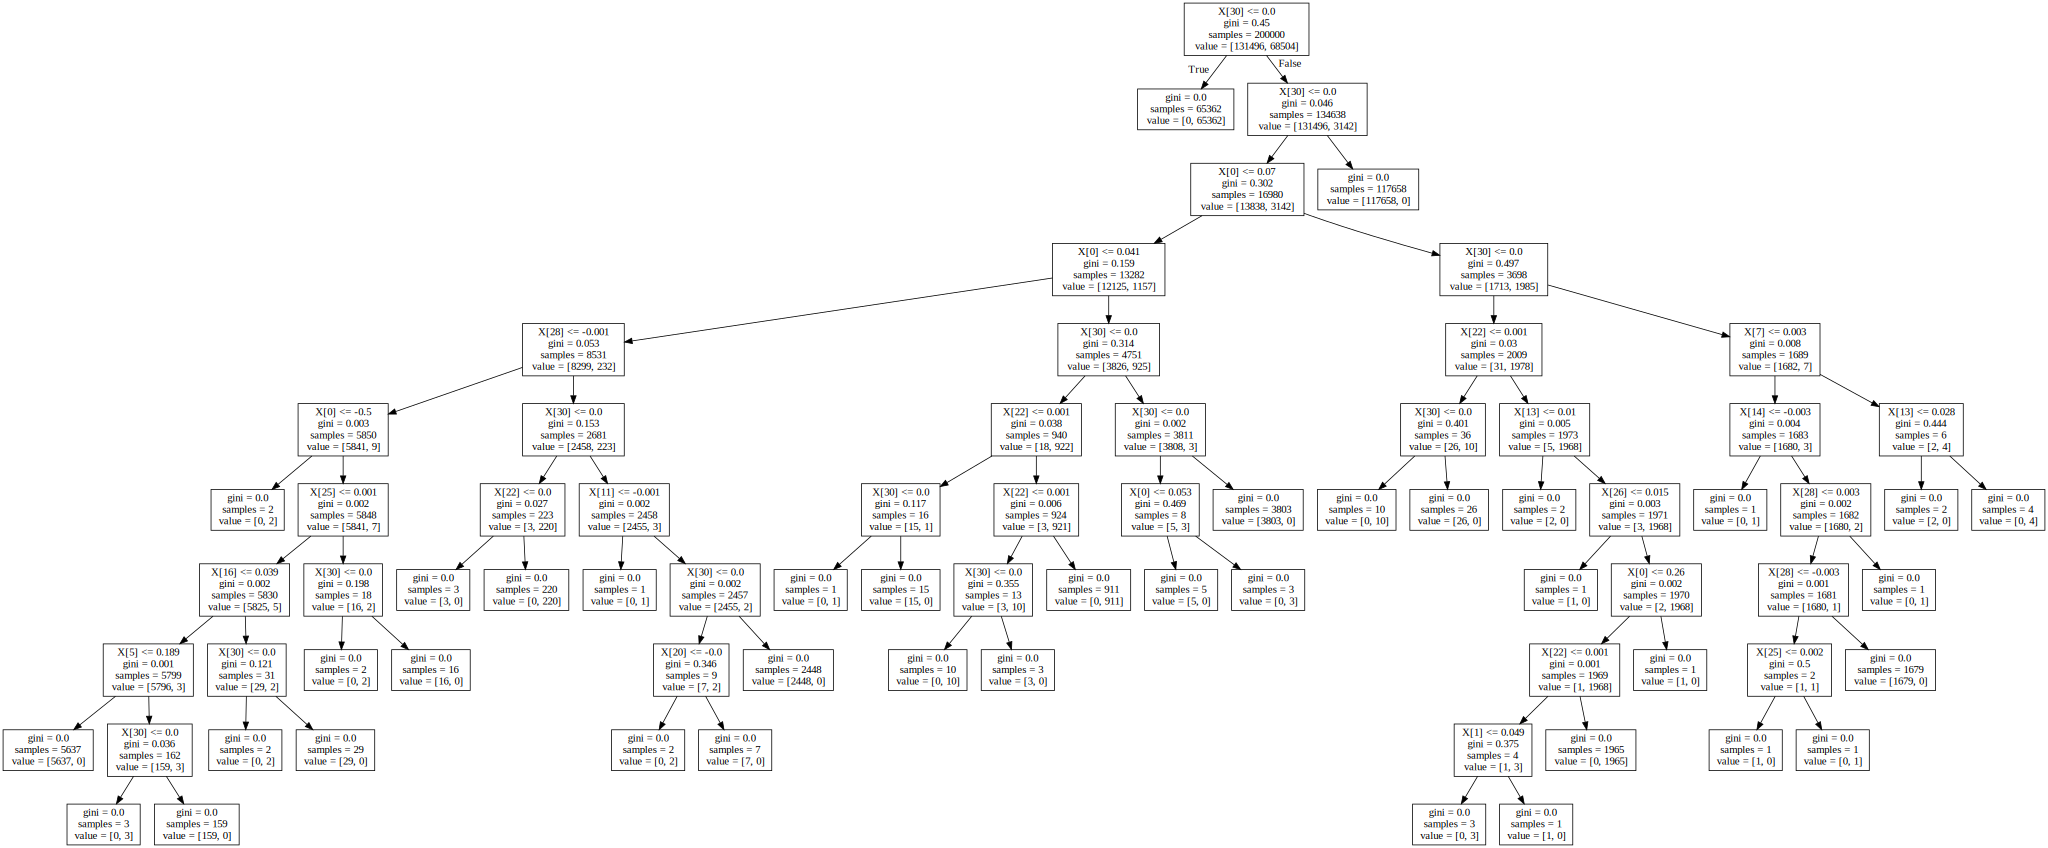

In [ ]:
grafTree = tree.export_graphviz(arbolGini, out_file=None)
gv.Source(grafTree)

We see that the tree starts separating the samples from the attribute X[30] (Weight)

In [ ]:
arbolEntropy = classificationTree(X_train,Target_train,X_test,Target_test,"entropy")

Testing...
Confusion: 
[[32833     4]
 [    2 17161]]
Accuracy :  99.988
Report   : 
              precision    recall  f1-score   support

           b       1.00      1.00      1.00     32837
           s       1.00      1.00      1.00     17163

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000



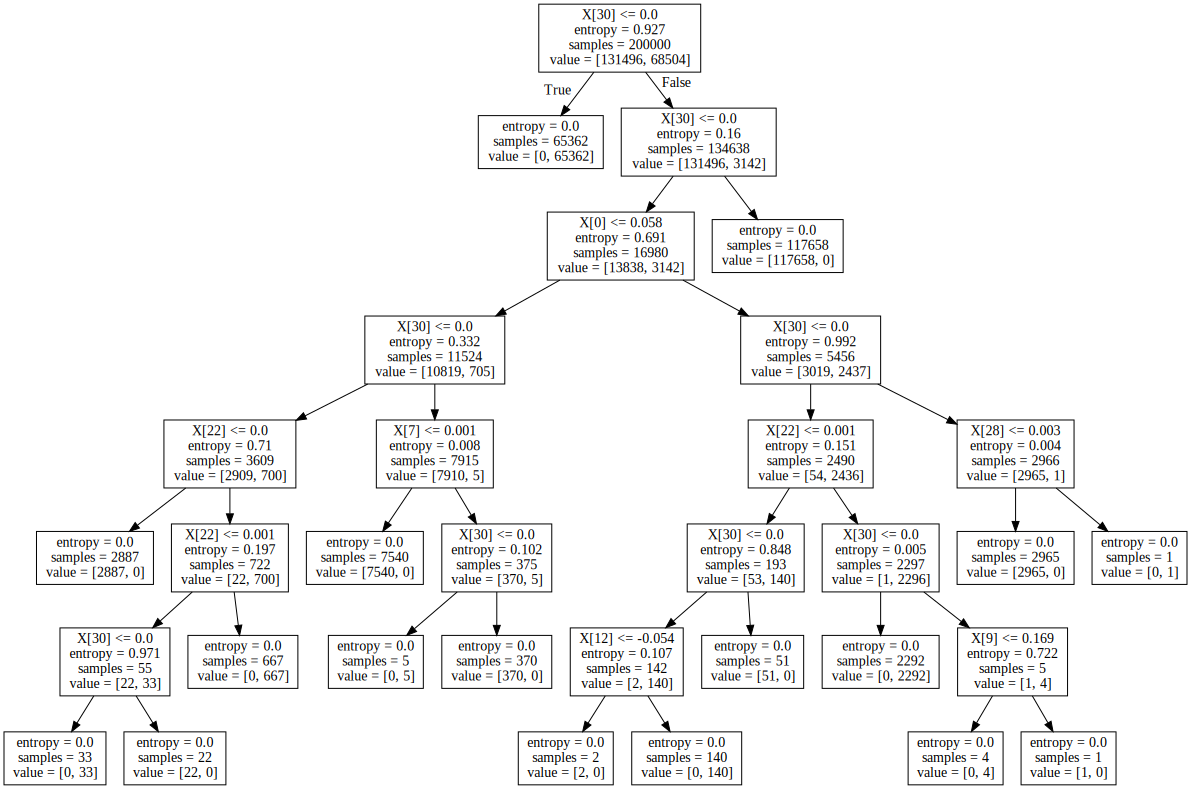

In [ ]:
grafTree = tree.export_graphviz(arbolEntropy, out_file=None)
gv.Source(grafTree)

## References

- ATLAS collaboration (2014). Dataset from the ATLAS Higgs Boson Machine Learning Challenge 2014. CERN Open Data Portal. DOI:10.7483/OPENDATA.ATLAS.ZBP2.M5T8
- Geeks for Geeks. *Decision tree implementation* Recovered from: https://www.geeksforgeeks.org/decision-tree-implementation-python/ 
- Scikit-learn. Machine Learning in Python. Pedregosa et al., JMLR 12, pp. 2825-2830, 2011
- Scikit-learn. *Feature selection*. Recovered from: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif
- Udacity (2016) *The Kaggle Challenge. Higgs Bosson*. Recovered from: https://www.youtube.com/watch?v=Sombn6OSvZU 
- Nguyen, D., Mejia Breton, K. & Cruz, I. (2016) *Kaggle Competition. Higgs Bosson Machine Learning Challenge*. NYC Data Science Academy. Recovered from: https://www.youtube.com/watch?v=Rn3dwmhVH3o 